# Run the pyWOMBAT biogeochemical model in 1D water column configuration

In [4]:
import sys
import os
import itertools
import logging
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci
from scipy.stats import qmc
import PyCO2SYS as pyco2
import matplotlib.pyplot as plt
import multiprocessing

# Ensure we are in the correct directory
os.chdir("/home/581/pjb581/py-WOMBAT/lite")
print(os.getcwd())
from main import main  # Import the main function from main.py

# Define output directory and ensure it exists (MAKE SURE A FORWARD SLASH EXISTS AT END)
OUTPUT_DIR = "/g/data/es60/pjb581/py-WOMBAT/output/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("PyCO2SYS version =", pyco2.__version__)

print(datetime.now())

"""
NOTE: Need read permissions for groups es60, gb6, qv56
"""

/home/581/pjb581/py-WOMBAT/lite
python version = 3.10.
numpy version = 1.24.4
xarray version = 2023.8.0
scipy version = 1.15.1
PyCO2SYS version = 1.8.3.4
2025-04-25 12:42:57.628643


'\nNOTE: Need read permissions for groups es60, gb6, qv56\n'

## Define the experimental parameters

In [5]:
### Generate a random sobol sequence for sampling the parameter set

dim = 13  # number of parameters
sampler = qmc.Sobol(d=dim, scramble=True, seed=10)
sample_qmc = sampler.random(n=512)  #here, n=256=2^8 
sample_qmc.shape


(512, 13)

In [6]:

samples = sample_qmc
np.shape(samples)

ranges = {
    "var": ["zoo_respi", "zoo_qmort", "zoo_assim", "zoo_excre", 
            "zoo_grz", "zooepsmin", "zoo_epsmax", "zoo_epsmid", 
            "zoo_epsrat", "zoo_inerti", "zoo_prefdet", "detrem", "w0"],
    "min": [1e-4, 1e-1, 1e-1, 1e-1, 1e-1, 1e-2, 1e-1, 0.5, 1.0, 1.0,  1e-1, 5e-2,   10.0],
    "max": [1e-1, 9e-1, 9e-1, 9e-1, 5.0,  1e-1, 1.0,  3.5, 6.0, 60.0, 9e-1, 9.5e-1, 30.0]
}

param_ranges = pd.DataFrame(ranges)
param_ranges


,var,min,max
0,zoo_respi,0.0001,0.10
1,zoo_qmort,0.1000,0.90
2,zoo_assim,0.1000,0.90
3,zoo_excre,0.1000,0.90
4,zoo_grz,0.1000,5.00
5,zooepsmin,0.0100,0.10
6,zoo_epsmax,0.1000,1.00
7,zoo_epsmid,0.5000,3.50
8,zoo_epsrat,1.0000,6.00
9,zoo_inerti,1.0000,60.00


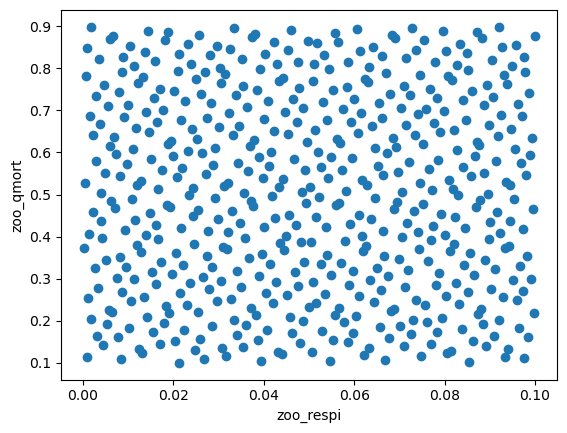

In [7]:
### Determine the experimental values
param_sample = np.zeros((512,dim))
for ii in np.arange(dim):
    param_sample[:,ii] = param_ranges['min'][ii] + (param_ranges['max'][ii] - param_ranges['min'][ii]) * samples[:,ii]

### Take a quick look
plt.figure()
plt.scatter(param_sample[:,0], param_sample[:,1])
plt.xlabel(param_ranges['var'][0])
plt.ylabel(param_ranges['var'][1])

### Define the other inputs to the model
'''
Polar Southern = 1E, 65S
Westerlies Southern = 20E, 45S
Tropical Pacific = 235E, Eq
Westerlies Atlantic = 340E, 30N
'''

year = 2001
days = 365*5
lon = 340.0
lat = 30.0
atm_co2 = 400.0
grazform = 2

info = np.array([year, days, lon, lat, atm_co2])
info = np.repeat(info[np.newaxis, :], 512, axis=0).T
# Add year, daylength, longitude, latitude and atmospheric CO2
param_sample = np.insert(param_sample, 0, info, axis=1)
# Add grazing formulation
param_sample = np.insert(param_sample, 16, grazform, axis=1)
# Add experiment number
param_sample = np.insert(param_sample, 0, np.arange(0,512,1, dtype=int), axis=1)


## Save parameter sets in excel

In [8]:
names = ["expnum", "year", "days", "longitude", "latitude", "atmCO2", 
         "zoorespi", "zooqmort", "zooassim", "zooexcre", "zoogrz", 
         "zooepsmin", "zooepsmax", "zooepsmid", "zooepsrat", 
         "zooinerti", "zooprefdet", "grazform", "detrem", "w0"]

paramsets = pd.DataFrame(param_sample, columns=names)
paramsets = paramsets.drop(columns=["grazform"])
paramsets

,expnum,year,days,longitude,latitude,atmCO2,zoorespi,zooqmort,zooassim,zooexcre,zoogrz,zooepsmin,zooepsmax,zooepsmid,zooepsrat,zooinerti,zooprefdet,detrem,w0
0,0.0,2001.0,1825.0,340.0,30.0,400.0,0.098711,0.741914,0.109181,0.240620,4.166826,0.011834,0.125761,1.417272,4.591252,5.119172,0.539276,0.835263,24.063456
1,1.0,2001.0,1825.0,340.0,30.0,400.0,0.007677,0.162206,0.742353,0.780016,1.569612,0.095465,0.550492,2.660584,2.321941,31.152094,0.416940,0.471438,15.704579
2,2.0,2001.0,1825.0,340.0,30.0,400.0,0.047306,0.671950,0.453010,0.472043,0.805058,0.066550,0.535597,3.115591,1.840268,45.907672,0.122459,0.103891,29.033834
3,3.0,2001.0,1825.0,340.0,30.0,400.0,0.059097,0.429789,0.698572,0.507529,3.706437,0.040570,0.988013,0.982427,5.364329,19.856731,0.846361,0.640312,11.144391
4,4.0,2001.0,1825.0,340.0,30.0,400.0,0.074526,0.526462,0.849174,0.690454,3.133493,0.025540,0.344012,3.303791,1.345132,39.573962,0.260498,0.501932,26.437287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,507.0,2001.0,1825.0,340.0,30.0,400.0,0.074318,0.370163,0.661750,0.131411,4.659733,0.066421,0.920409,2.481095,2.196836,34.547199,0.318818,0.320045,27.084665
508,508.0,2001.0,1825.0,340.0,30.0,400.0,0.059280,0.673589,0.812376,0.264312,4.008272,0.086897,0.383490,1.805489,5.757747,24.739222,0.586089,0.428665,10.502706
509,509.0,2001.0,1825.0,340.0,30.0,400.0,0.047123,0.428151,0.239164,0.706067,1.718645,0.025674,0.858758,2.298754,1.154499,57.243492,0.457694,0.735664,29.641310
510,510.0,2001.0,1825.0,340.0,30.0,400.0,0.007859,0.743407,0.556095,0.448122,1.258200,0.054768,0.255016,3.477420,3.173037,42.488830,0.150612,0.710012,15.141134


In [7]:
#paramsets.to_excel("/g/data/es60/pjb581/py-WOMBAT/parametersets_grazing.xlsx", index=False)

## Run the experiments

In [10]:
# setup the log file for each experiment
def setup_logging():
    log_file = f"experiment_output_{multiprocessing.current_process().pid}.log"
    logging.basicConfig(filename=log_file, level=logging.INFO, format="%(asctime)s - %(message)s")


# Define function to run one experiment
def run_experiment(exp):

    setup_logging()
    
    expnum, yr, dayl, lon, lat, atm_co2, zoo_respi, zoo_qmort, zoo_assim, zoo_excre, zoo_grz, zoo_epsmin, zoo_epsmax, zoo_epsmid, zoo_epsrat, zoo_inerti, zoo_prefdet, grazform, detrem, w0 = exp
    
    logging.info(f"\n🚀 Running Experiment with Params: {exp}")
    logging.info(f"Process {multiprocessing.current_process().pid} started at {datetime.now()}")
    
    # Run the main function with these parameters
    main(expnum, yr, dayl, lon, lat, atm_co2, zoo_respi, zoo_qmort, zoo_assim, zoo_excre, zoo_grz, zoo_epsmin, zoo_epsmax, zoo_epsmid, zoo_epsrat, zoo_inerti, zoo_prefdet, grazform, detrem, w0)

    logging.info(f"Process {multiprocessing.current_process().pid} finished at {datetime.now()}")
    logging.info(f"✅ Experiment Complete: {exp}")
    


In [11]:
### Cut out the experiments already run
done = set()
for fn in os.listdir(OUTPUT_DIR):
    if "exp" in fn and fn.endswith(".nc"):
            try:
                # Extract the experiment number
                exp_str = fn.split("exp")[-1].split(".nc")[0]
                expnum = int(exp_str)
                done.add(expnum)
            except ValueError:
                # In case conversion fails, skip this file
                continue

param_sample_todo = [exp for exp in param_sample if exp[0] not in done]
np.shape(param_sample_todo)

(512, 20)

In [ ]:
# Run experiments in parallel using multiprocessing
if __name__ == "__main__":
    num_processes = min(min(multiprocessing.cpu_count(), 16), len(param_sample_todo))  # Use at most the available cores to a max of 16
    print("Running %i parallel experiments"%(num_processes))
    with multiprocessing.Pool(processes=num_processes) as pool:
        pool.map(run_experiment, param_sample_todo)

    # Check generated output files
    output_files = os.listdir("output")
    print("\nGenerated output files:", output_files)
    

Running 16 parallel experiments
